<a href="https://colab.research.google.com/github/hatimnaitlho/ml-sklearn/blob/master/breast_cancer_prediction_using_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Diagnosis using Supervised Machine Learning Algorithms

In this notebook we will build, assess and tune some classifiers. The goal is to build a classifier that have 100% recall, and up to 95% precision. The classifiers will be trained and assessed based on the Wisconsin Breast Cancer diagnosis dataset.

This dataset is computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.




In this notebook we will build, assess and tune ExtraTreeClassifier with 100% recall, and up to 95% precision. The classifier will be trained and assessed based on the `Wisconsin Breast Cancer diagnosis dataset`. 

This dataset is computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

### Accuracy vs Recall vs Precision?
Imagine that we built a model that gives an accuracy_score of 98%. The score may seem good, but what if accuracy is not pertinent in our case.
So, let's dive on the meaning of accuracy to unterstand better the notion of this performance metric.
Accuracy will answer to the follwing question: 
- how often is the classifier correct? 
Thus, we can say that our model is correct 98% of time. So, for 1000 patients, the model is able to predict correctly 980 of the cases, which can be considered as a very good performance.
Now, let's imagine that the model fails in classifing 10 malignant tumors. The accuracy is still 98%, but 10 sick patients were sent home without treatment, which will represent  a catastroph!

This is why, accuracy is not considered as the good performance metric in our context (prediction if a tumor is malignant or benign). 

We need instead, `Precision` and `Recall` metrics which are more relevant.

- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

- Recall is The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

`Recall is more important than precision in a breast cancer predictor`


In [2]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns


# to make this notebook's output reproducible across runs
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading the cancer dataset

In [0]:
from sklearn import datasets

cancer_dataset = datasets.load_breast_cancer()

# Exploring the cancer dataset

In [4]:
cancer_dataset.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [5]:
print(cancer_dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

# Exploratory Data Analysis & Features Selection

Let's build the cancer breast dataframe based on `'data'` and `'feature_names'`, which is more convenient.

In [6]:
df = pd.DataFrame(data=cancer_dataset.data, columns=list(cancer_dataset.feature_names))
df['target']= cancer_dataset.target
df.tail(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
559,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,0.06570,0.2388,2.904,1.936,16.97,0.008200,0.029820,0.05738,0.01267,0.01488,0.004738,12.480,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732,1
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.492,2.888,29.84,0.007256,0.026780,0.02071,0.01626,0.02080,0.005304,15.300,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321,1
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,0.3141,3.896,2.041,22.81,0.007594,0.008878,0.00000,0.00000,0.01989,0.001773,11.920,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905,1
562,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,0.2602,1.205,2.362,22.65,0.004625,0.048440,0.07359,0.01608,0.02137,0.006142,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090,0
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.026,8.758,118.80,0.006399,0.043100,0.07845,0.02624,0.02057,0.006213,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873,0
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.028910,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.024230,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.037310,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.061580,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.004660,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039,1


In [7]:
print('Data Set Characteristics:')
print('The Number of Instances is: {}'.format(df.shape[0]))
print('The Number of Attributes is: {}'.format(df.shape[1]-1))

Data Set Characteristics:
The Number of Instances is: 569
The Number of Attributes is: 30


In [8]:
# Fill empty and NaNs values with NaN
df = df.fillna(np.nan)

# Check for Null values
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

### Features selection
Let's first plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable `target`.

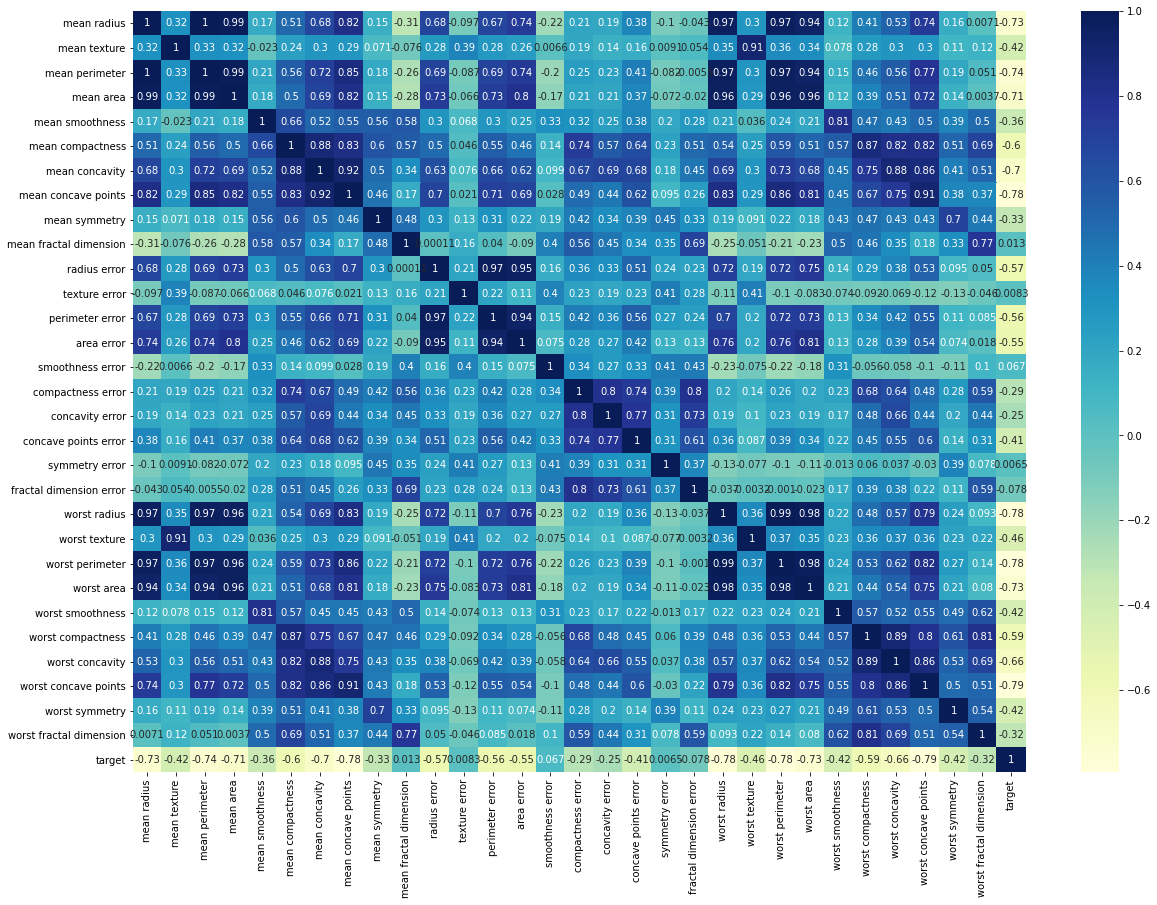

In [9]:
# Correlation matrix
cor = df.corr()

plt.figure(figsize = (20,14))

g = sns.heatmap(df.corr(), annot=True, cmap = 'YlGnBu')

#### Relevant features
We will choose a treshold to filter features based on their correlation with the target.

In [10]:
#Correlation with the output variable
treshold= 0.3
cor_target = abs(cor['target'])
#Selecting moderate to highly correlated features
relevant_features = cor_target[cor_target>=treshold]
print('The number of highly relevant features is: {}'.format(relevant_features.shape[0]))
relevant_features

The number of highly relevant features is: 24


mean radius                0.730029
mean texture               0.415185
mean perimeter             0.742636
mean area                  0.708984
mean smoothness            0.358560
mean compactness           0.596534
mean concavity             0.696360
mean concave points        0.776614
mean symmetry              0.330499
radius error               0.567134
perimeter error            0.556141
area error                 0.548236
concave points error       0.408042
worst radius               0.776454
worst texture              0.456903
worst perimeter            0.782914
worst area                 0.733825
worst smoothness           0.421465
worst compactness          0.590998
worst concavity            0.659610
worst concave points       0.793566
worst symmetry             0.416294
worst fractal dimension    0.323872
target                     1.000000
Name: target, dtype: float64

In [11]:
features_to_drop = cor_target[cor_target<0.3]
features_to_drop

mean fractal dimension     0.012838
texture error              0.008303
smoothness error           0.067016
compactness error          0.292999
concavity error            0.253730
symmetry error             0.006522
fractal dimension error    0.077972
Name: target, dtype: float64

Now let's drop the features considered as having low correlation with the target. `mean fractal dimension`, `texture error`, `smoothness error`, `compactness error`, `concavity error`, `symmetry error`, `fractal dimension error`

In [0]:
dfc= df.copy()
dfc.drop(columns=['mean fractal dimension', 'texture error', 'smoothness error', 'compactness error', 
                  'concavity error', 'symmetry error', 'fractal dimension error'], inplace= True)

In [0]:
X= dfc.drop(columns=['target'])
y= dfc['target']

# Support Vector Machine (SVM)

## Building the model

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

#### Feature Scaling

Let's normalize the model using `StandardScaler`

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

Now, let's build the SVM model using the linear kernel, all other parameters are set to defaults.

In [0]:
from sklearn.svm import SVC

clf = SVC(kernel='linear') 

clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = clf.predict(X_test)

## Evaluating the Model
Let's estimate how the classifier performs when predicting the breast cancer of patients (for unseen data).


In [0]:
from sklearn.metrics import accuracy_score

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9736842105263158


Well, you got a classification rate of 97.37%, which answers to the question: how often is the classifier correct?
This can be considered as a very good accuracy. 

However, `accuracy` is not considered as the good metric in our context (prediction if a tumor is malignant or benign). We need instead, Precision and recall metrics which are more relevant.


In [0]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Model Recall: what percentage of malignant tumors are labelled as such?
print("Recall:", recall_score(y_test, y_pred))
# Model Precision: what percentage of malignant tumors are labeled as such?
print("Precision:", precision_score(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

Recall: 0.9859154929577465
Precision: 0.9722222222222222
Accuracy: 0.9736842105263158


In [0]:
from sklearn.metrics import confusion_matrix


col= ['predicted "Malignant"', 'predicted "Benign"']
rws= ['Malignant', 'Benign']
cm= confusion_matrix(y_test, y_pred, labels=[1,0])
df_mc=pd.DataFrame(data= cm, index=rws, columns=col)
df_mc

,"predicted ""Malignant""","predicted ""Benign"""
Malignant,70,1
Benign,2,41


Well, we got a recall of 98.59% and a precision of 97.22%, which are considered as very good values. However for each 1140 patients we will have 10 sick women that are told that they are not sick, and send home without treatment, which is very dangerous. So we need to improve the recall from the actual value to 1.

We have to tune hyperparameters, C, gamma and Kernel.

## Tuning the SVM hyperparameters

The kernel will have more influence in the recall than C which is a penalty parameters (penalizes classification error)

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

kernels= ['poly', 'rbf']
Cs= [1.0, 10.0, 100.0]
gammas = [0.001, 0.01, 0.1, 1]

parameter_grid = {'kernel': kernels, 'C': Cs, 'gamma' : gammas}

clf = GridSearchCV(estimator=SVC(), 
                    param_grid=parameter_grid,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf.fit(X_train, y_train)
optimised_svm = clf.best_estimator_
print(clf.best_params_)


{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


In [0]:
print('The best parameters of the SVM are:')
print(clf.best_params_)

The best parameters of the SVM are:
{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


# The Optimised Support Vector Machine

In [0]:
from sklearn.svm import SVC
clf_best= SVC(kernel='rbf', C=10, gamma= 0.01)
clf_best.fit(X_train, y_train)
y_pred_new = clf_best.predict(X_test)

In [0]:
# Model Recall: what percentage of malignant tumors are labelled as such?
print("Recall:", recall_score(y_test, y_pred_new))
# Model Precision: what percentage of malignant tumors are labeled as such?
print("Precision:", precision_score(y_test, y_pred_new))

print("Accuracy:", accuracy_score(y_test, y_pred_new))

Recall: 1.0
Precision: 0.9726027397260274
Accuracy: 0.9824561403508771


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

col= ['predicted "Malignant"', 'predicted "Benign"']
rws= ['Malignant', 'Benign']
cm= confusion_matrix(y_test, y_pred_new, labels=[1,0])
df_mc=pd.DataFrame(data= cm, index=rws, columns=col)
df_mc

,"predicted ""Malignant""","predicted ""Benign"""
Malignant,71,0
Benign,2,41


# Ensemble Methods, KNN, Decision Tree & Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier



classifiers= [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), 
              AdaBoostClassifier(), KNeighborsClassifier(3), BaggingClassifier(), ExtraTreesClassifier() ]



l1, l2, l3 =([] for i in range(3))

metrics_dict = {}



for clf in classifiers:
  clf.fit(X_train, y_train)
  clf.predict(X_test)
  name= clf.__class__.__name__
  l1.append(name)
  metrics_dict['model']= l1
  l2.append(recall_score(y_test, clf.predict(X_test)))
  metrics_dict['recall_score']= l2
  l3.append(precision_score(y_test, clf.predict(X_test)))
  metrics_dict['precision_score'] = l3


df = pd.DataFrame(metrics_dict)
df

,model,recall_score,precision_score
0,LogisticRegression,0.985915,0.972222
1,DecisionTreeClassifier,0.929577,0.942857
2,RandomForestClassifier,0.985915,0.958904
3,AdaBoostClassifier,0.985915,0.958904
4,KNeighborsClassifier,0.971831,0.971831
5,BaggingClassifier,0.943662,0.957143
6,ExtraTreesClassifier,0.971831,0.971831


`ExtraTreesClassifier` and `LogisticRegression` give the best results in this set of classifiers. However, as we will see the recall of `ExtraTreesClassifier` doesn't improve and stay at the same value, even when we improve the tuning of its hyperparameters. 

In this case, we will have to iterate and focus on features selection to see if we can improve the model. 

# ExtraTreesClassifier

### Tuning RandomForestClassifier hyperparameters

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

scorer= make_scorer(recall_score)

n_estimators = [15, 20, 30, 40, 50]
max_depth = [25, 30, 35, 40, 45]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [2, 5, 10] 

parameter_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,  
                  'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}


clf_grid = GridSearchCV(estimator=ExtraTreesClassifier(), 
                    param_grid=parameter_grid,
                    scoring= scorer,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf_grid.fit(X_train, y_train)

optimised_extratree = clf_grid.best_estimator_
print(clf_grid.best_params_)

{'max_depth': 30, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 15}


In [0]:
y_pred_ET=optimised_extratree.predict(X_test)

In [0]:
# Model Recall: what percentage of malignant tumors are labelled as such?
print("Recall:", recall_score(y_test, y_pred_ET))
# Model Precision: what percentage of malignant tumors are labeled as such?
print("Precision:", precision_score(y_test, y_pred_ET))

Recall: 0.9859154929577465
Precision: 0.9459459459459459


Tuning hyperparameters using GridSearchCV method did not improve the performance of the Extra Tree Model (the precision actually decreased). 

However, performing more advanced filtering features using the “feature_importances_” attribute of the Extra tree was quite helpful and ultimately boosted the accuracy of the final model.

## Filtering features using the `feature_importances_` attribute

In [0]:
optimised_extratree.feature_importances_

array([1.21660874e-01, 1.20050968e-02, 6.19606473e-02, 4.21544245e-02,
       1.06153862e-02, 8.35002634e-03, 5.37409434e-02, 2.53103421e-01,
       2.55564512e-03, 2.23750260e-03, 1.02737628e-03, 6.12672646e-02,
       2.44206100e-05, 1.07626331e-01, 1.67566379e-02, 3.41402503e-02,
       7.07632189e-02, 9.40122000e-03, 6.51293368e-03, 1.62971709e-02,
       9.83971976e-02, 1.99957582e-04, 9.20205403e-03])

In [0]:
keys= list(X.columns)
values= list(optimised_extratree.feature_importances_)
new_dict = dict(zip(keys, values))

In [0]:
lf=[]
for (k,v) in new_dict.items(): 
  if v>0.01:
    lf.append(k)
print(lf)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


In [0]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,radius error,perimeter error,area error,concave points error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,1.0950,8.589,153.40,0.01587,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.5435,3.398,74.08,0.01340,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.7456,4.585,94.03,0.02058,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.4956,3.445,27.23,0.01867,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.7572,5.438,94.44,0.01885,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [0]:
Xr=X.copy()
Xr= Xr[lf]
Xr.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean concavity,mean concave points,area error,worst radius,worst texture,worst perimeter,worst area,worst concavity,worst concave points
0,17.99,10.38,122.80,1001.0,0.11840,0.3001,0.14710,153.40,25.38,17.33,184.60,2019.0,0.7119,0.2654
1,20.57,17.77,132.90,1326.0,0.08474,0.0869,0.07017,74.08,24.99,23.41,158.80,1956.0,0.2416,0.1860
2,19.69,21.25,130.00,1203.0,0.10960,0.1974,0.12790,94.03,23.57,25.53,152.50,1709.0,0.4504,0.2430
3,11.42,20.38,77.58,386.1,0.14250,0.2414,0.10520,27.23,14.91,26.50,98.87,567.7,0.6869,0.2575
4,20.29,14.34,135.10,1297.0,0.10030,0.1980,0.10430,94.44,22.54,16.67,152.20,1575.0,0.4000,0.1625


## Spliting and normalizing the data

In [0]:
Xr_train, Xr_test, yr_train, yr_test= train_test_split(Xr, y, test_size=0.2,random_state=42)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  
Xr_train = scaler.fit_transform(Xr_train)  
Xr_test = scaler.transform(Xr_test)

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

scorer= make_scorer(recall_score)

n_estimators = [15, 20, 30, 40, 50]
max_depth = [25, 30, 35, 40, 45]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [2, 5, 10] 

parameter_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,  
                  'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}


clf_grid = GridSearchCV(estimator=ExtraTreesClassifier(), 
                    param_grid=parameter_grid,
                    scoring= scorer,
                    cv=5,
                    refit=True,
                    error_score=0,
                    n_jobs=-1)

clf_grid.fit(Xr_train, yr_train)

optimised_extratreeclf = clf_grid.best_estimator_
print(clf_grid.best_params_)


{'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 50}


In [0]:
prediction=optimised_extratreeclf.predict(Xr_test)

In [0]:
# Model Recall: what percentage of malignant tumors are labelled as such?
print("Recall:", recall_score(yr_test, prediction))
# Model Precision: what percentage of malignant tumors are labeled as such?
print("Precision:", precision_score(yr_test, prediction))

print("Accuracy:", accuracy_score(yr_test, prediction))

Recall: 1.0
Precision: 0.9726027397260274
Accuracy: 0.9824561403508771


Well, now we have improved our model with a recall equal to 1.0.
The model is now able to handle the prediction tasks of malignant tumors. 


In [0]:
from sklearn.metrics import confusion_matrix


col= ['predicted "Malignant"', 'predicted "Benign"']
rws= ['Malignant', 'Benign']
mc= confusion_matrix(yr_test, prediction, labels=[1,0])
df_mc_ET=pd.DataFrame(data= mc, index=rws, columns=col)
df_mc_ET

,"predicted ""Malignant""","predicted ""Benign"""
Malignant,71,0
Benign,2,41


# Conclusion: 

Based on the Wisconsin Breast Cancer diagnosis dataset, we have built two classifiers (SVM, and Extra Tree classifier) that performs very well in predicting breast malignant tumors. 

For the SVM, we achieved the goal of recall_score=1 by filtering features (from 30 to 23 based on their correlation coefficients), and using the GridSearchCV.

For the ExtraTreeClassifier, the model doesn't improve, and we had to reiterate to the step features selection. For that, we used the feature_importances_ attribute, which get the feature importance of each feature of our dataset. We reduced the set of features from 23 to 13.

The two models produced the same performance based on the selected metrics (recall = 1.0, precision = 0.97, accuracy = 0.98).

